In [162]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [163]:
# Data loading
dir_path = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
data_path = os.path.join(dir_path, "Concrete_processed_data.xlsx")
df = pd.read_excel(data_path)
df.head(10)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",water_cement_ratio,water_binder_ratio,agg_binder_ratio,total_binder_content,total_mix,cement_ratio,log_age,age_group,slag_age_interaction,cement_age_interaction,sp_flag,slag_flag
0,540.0,0.0,0.0,162.0,2.5,28,79.986111,0.300000,0.30000,3.177778,540.0,2418.0,1.0,3.367296,Standard,0.000000,1818.339748,1,0
1,540.0,0.0,0.0,162.0,2.5,28,61.887366,0.300000,0.30000,3.205556,540.0,2433.0,1.0,3.367296,Standard,0.000000,1818.339748,1,0
2,332.5,142.5,0.0,228.0,0.0,270,40.269535,0.685714,0.48000,3.212632,475.0,2229.0,0.7,5.602119,Long-term,798.301932,1862.704508,0,1
3,332.5,142.5,0.0,228.0,0.0,365,41.052780,0.685714,0.48000,3.212632,475.0,2229.0,0.7,5.902633,Long-term,841.125250,1962.625583,0,1
4,198.6,132.4,0.0,192.0,0.0,360,44.296075,0.966767,0.58006,5.449849,331.0,2326.9,0.6,5.888878,Long-term,779.687442,1169.531163,0,1
5,266.0,114.0,0.0,228.0,0.0,90,47.029847,0.857143,0.60000,4.215789,380.0,2210.0,0.7,4.510860,Mature,514.237984,1199.888629,0,1
6,380.0,95.0,0.0,228.0,0.0,365,43.698299,0.600000,0.48000,3.212632,475.0,2229.0,0.8,5.902633,Long-term,560.750167,2243.000667,0,1
7,380.0,95.0,0.0,228.0,0.0,28,36.447770,0.600000,0.48000,3.212632,475.0,2229.0,0.8,3.367296,Standard,319.893104,1279.572415,0,1
8,266.0,114.0,0.0,228.0,0.0,28,45.854291,0.857143,0.60000,4.215789,380.0,2210.0,0.7,3.367296,Standard,383.871725,895.700691,0,1
9,475.0,0.0,0.0,228.0,0.0,28,39.289790,0.480000,0.48000,3.212632,475.0,2229.0,1.0,3.367296,Standard,0.000000,1599.465519,0,0


In [164]:
df.dtypes

Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
water_cement_ratio                                       float64
water_binder_ratio                                       float64
agg_binder_ratio                                         float64
total_binder_content                                     float64
total_mix                                                float64
cement_ratio                                             float64
log_age                                                  float64
age_group                                                    str
slag_age_interaction     

In [165]:
df.shape

(1005, 19)

In [166]:
# Defining x and y
df.columns.str.strip()
target = 'Concrete compressive strength(MPa, megapascals)'
X = df.drop(columns=[target])
y = df[target]

print(X.shape)
print(y.shape)

(1005, 18)
(1005,)


In [167]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42, shuffle = True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(804, 18)
(201, 18)
(804,)
(201,)


In [168]:
y_test.describe()

count    201.000000
mean      35.984128
std       17.315305
min        2.331808
25%       23.800712
50%       34.569637
75%       46.898158
max       82.599225
Name: Concrete compressive strength(MPa, megapascals), dtype: float64

In [169]:
y_train.describe()

count    804.000000
mean      35.066809
std       16.022885
min        3.319827
25%       23.218597
50%       33.737784
75%       44.390189
max       79.986111
Name: Concrete compressive strength(MPa, megapascals), dtype: float64

### Why Check Mean and Std of y_train and y_test

When splitting a dataset into training and test sets, the **target variable distribution** should be roughly the same in both sets.

- **Mean similarity:** Ensures that the average target value is consistent between train and test.
  - If one set has mostly high values and the other low, the model might see biased patterns during training.

- **Standard deviation similarity:** Ensures that the variability of the target is similar in both sets.
  - This helps the model generalize well, rather than overfitting to the narrower range of values in the training set.

**Summary:** Close mean and std in `y_train` and `y_test` confirms that the split preserves the overall target distribution, giving a fair evaluation during testing.

In [170]:
# Removing outlier on the training data only to prevent data leakage
def detecting_outlier_iqr(y_train):

    Q1 = y_train.quantile(0.25)
    Q3 = y_train.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (y_train < lower_bound) | (y_train > upper_bound)

    return outliers

outliers = detecting_outlier_iqr(y_train)
print(outliers.sum())

5


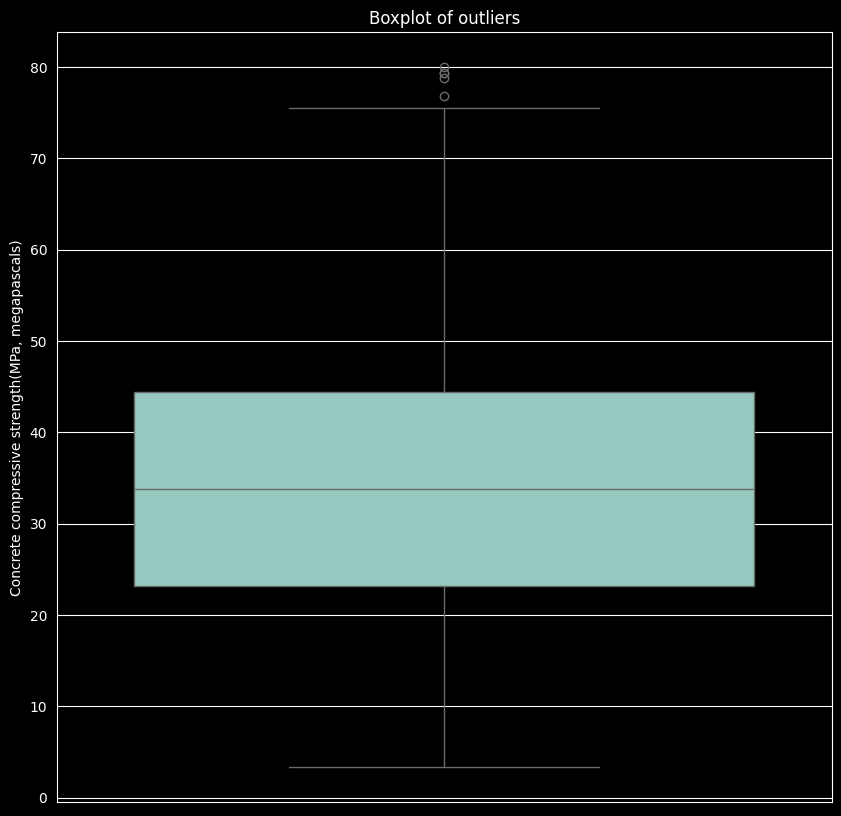

In [171]:
# Visualizing the outliers
plt.figure(figsize=(10,10))
sns.boxplot(data= y_train)
plt.title("Boxplot of outliers")
plt.xticks(rotation = 45)
plt.show()

In [172]:
outliers_mask = detecting_outlier_iqr(y_train)
y_train_clean = y_train[~outliers_mask]  # remove outliers  using ~ o tilde ensures to return true where the data is clean
X_train_clean = X_train[~outliers_mask]  # remove same rows from features

X_train_clean = X_train_clean.reset_index(drop=True)
y_train_clean = y_train_clean.reset_index(drop=True)

In [173]:
print(X_train_clean.shape)
print(y_train_clean.shape)

(799, 18)
(799,)


### Why Remove Target Outliers Only

When cleaning data for regression, focus on **target (`y`) outliers**, not the feature (`X`) outliers.

- **Impact of target outliers:** Extreme values in the target can disproportionately influence the regression line, causing poor predictions on normal samples.
- **Impact of feature outliers:** Many models, especially tree-based ones, are robust to extreme feature values, so removing them is often unnecessary.

**Summary:** Removing only target outliers prevents the model from being skewed by extreme responses, while preserving the natural variability of the features.

**Note:** Always remove outliers **only from the training set** to avoid leaking information from the test set.

## SKLEARN ML PIPELINE

In [174]:
# Setting up the numeric transformer
# Identifying column types
numerical_features = [col for col in X_train.columns
                      if col != target and col!= "age_group"
                      ]
categorical_features = ['age_group']

# Combining the  two to a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Creating the linear regression pipeline.
lr_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

print(lr_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cement (component 1)(kg in '
                                                   'a m^3 mixture)',
                                                   'Blast Furnace Slag '
                                                   '(component 2)(kg in a m^3 '
                                                   'mixture)',
                                                   'Fly Ash (component 3)(kg '
                                                   'in a m^3 mixture)',
                                                   'Water  (component 4)(kg in '
                                                   'a m^3 mixture)',
                                                   'Superplasticizer '
                                                   '(component 5)(kg in a m^3 '
                                                   'mixture)',
           

In [175]:
print(numerical_features)

['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Age (day)', 'water_cement_ratio', 'water_binder_ratio', 'agg_binder_ratio', 'total_binder_content', 'total_mix', 'cement_ratio', 'log_age', 'slag_age_interaction', 'cement_age_interaction', 'sp_flag', 'slag_flag']


In [176]:
# Fitting the pipeline to the training data
lr_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [ ]:
#  Making predictions.